# Проверка гипотез для сервиса аренды самокатов

Изучить и проанализировать данные о пользователях из нескольких городов и их поездках сервиса аренды самокатов, чтобы проверить гипотезы, способные помочь бизнесу расти.

Чтобы совершать поездки по городу, пользователи сервиса пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

### Описание данных


**Пользователи** — `users_go.csv`
- user_id — уникальный идентификатор пользователя
- name — имя пользователя
- age — возраст
- city — город
- subscription_type — тип подписки (free, ultra)

**Поездки** — `rides_go.csv`
- user_id — уникальный идентификатор пользователя
- distance — расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date — дата совершения поездки

**Подписки** - `subscriptions_go.csv`
- subscription_type — тип подписки
- minute_price — стоимость одной минуты поездки по данной подписке
- start_ride_price — стоимость начала поездки
- subscription_fee — стоимость ежемесячного платежа



### Импорт библиотек

In [1]:
# Стандартные библиотеки
import math
import numpy as np
# from math import sqrt
import re

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Модули проекта
# импорт модуля из библиотеки scipy
import scipy.stats as st

# Сторонние библиотеки
import pandas as pd

### Функции

#### f_read_and_info

In [2]:
def f_read_and_info(filename, parse_dates=None):
    """
    Загружает CSV-файл из двух возможных путей и выводит информацию о DataFrame.

    Args:
        filename (str): имя файла
        parse_dates (list, optional): список колонок, которые нужно преобразовать в даты

    Returns:
        df (pd.DataFrame): Датафрейм
    """
    
    # путь
    pth1 = ''

    try:
        df = pd.read_csv(pth1+filename, parse_dates=parse_dates)
    except Exception as e:
        print(f'Файл не найден: {filename}')
        return None

    print(f'\n\n{'-'*25} Файл: {filename} {'-'*25}\n')

    # Переименование столбцов
    df.columns = [f_to_snake(col) for col in df.columns]

    # вывод первых строк
    display(df.head())

    # общая информация
    df.info()

    return df

#### f_to_snake

In [3]:
def f_to_snake(name):
    """
    Преобразует столбцы в змеиный регистр
    
    Args:
        name (str): исходное имя
    
    Returns:
        str: имя в snake_case
    """
    
    s1 = re.sub(r'(.)([A-Z][a-z]+)', r'\1_\2', name)
    s2 = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', s1)
    return s2.lower()

#### f_drop_duplicates

In [4]:
def f_drop_duplicates(df, name='Таблица'):
    """
    Функция удаляет дублирующие записи

    Args:
        df (pd.DataFrame): Датафрейм с данными
        name (str): Имя датафрейма

    Returns:
       df (pd.DataFrame): Датафрейм с удаленными дублирующими данными
    """
    
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        df = df.drop_duplicates()
        print(f'{name:<25}: Дубликаты удалены ({duplicates})')
    else:
        print(f'{name:<25}: Дубликатов нет')
    return df

#### f_boxplot_histplot_describe

In [5]:
def f_boxplot_histplot_describe(df, active_clients=None):
    """
    Строит гистограмму и диаграмму размаха для всех количественных признаков.

    Args:
        df (pd.DataFrame): Исходный датафрейм
        active_clients (pd.Series, optional): Таблица с активными клиентами (по умолчанию не используется)

    Returns:
        pd.DataFrame: Числовое описание диаграммы размаха
    """

    # учет только активных клиентов, если список есть
    if active_clients is not None:
        df = df.query('id in @ active_clients') 

    # цветовая палитра
    color=sns.color_palette('GnBu')[5]
    color2=sns.color_palette('GnBu')[4]

    # количественные признаки
    num_col_names = df.select_dtypes(include=['number', 'datetime']).columns.drop('id', errors='ignore')

    columns_continuous = []
    columns_discrete = []

    # определение непрерывных и дискретных признаков
    for columns_i in num_col_names:
        if len(df[columns_i].unique()) <= 15 and df[columns_i].dtype in ['int64', 'Int', 'int32']:
            columns_discrete.append(columns_i)
        else:
            columns_continuous.append(columns_i)
    
    if len(columns_continuous) == 1:
        column = columns_continuous[0]
        data = df[column]

        fig, axes = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [3, 1]})   # сетка графиков
        
        # гистограмма
        sns.histplot(data, bins=30, kde=True, color=color, ax=axes[0], stat="percent")
        axes[0].set_title(f'\nРаспределение {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Доля наблюдений (%)') # Частота

        # диаграмма размаха
        sns.boxplot(data, orient='h', ax=axes[1], boxprops=dict(facecolor='none'))
        
        plt.tight_layout()
        plt.show()

        display(pd.DataFrame(df[column].describe()))

    if len(columns_continuous) > 1:
        
        num_cols = 2                                                                            # количество столбцов
        num_rows = math.ceil(len(columns_continuous) / num_cols)                                # количество строк
        fig, axes = plt.subplots(num_rows * 2, num_cols, figsize=(7 * num_cols, 5 * num_rows),  # сетка графиков
                                 gridspec_kw={'height_ratios': [3, 1] * num_rows})              # гистограмма 3 части, boxplot 1 часть
        axes = np.array(axes).reshape(num_rows * 2, num_cols)                                   # преобразование в одномерную структуру
        
        for i, column in enumerate(columns_continuous):
            row, col = divmod(i, num_cols)                                                      # определение позиции в сетке
            data = df[column]
            
            # гистограмма
            sns.histplot(data, bins=50, kde=True, color=color, ax=axes[row * 2, col], stat='percent')
            axes[row * 2, col].set_title(f'\nРаспределение {column}')
            axes[row * 2, col].set_xlabel(column)
            axes[row * 2, col].set_ylabel('Доля наблюдений (%)')
    
            # диаграмма размаха
            sns.boxplot(data, orient='h', ax=axes[row * 2 + 1, col], boxprops=dict(facecolor='none'))

        # удаление пустых графиков
        for k in range(i+col, len(axes)):
            fig.delaxes(axes[k, (col + 1) % num_cols])

        plt.tight_layout()
        plt.show()
        
        display(df[columns_continuous].describe())


#### f_plot_bar

In [6]:
def f_plot_bar(df, active_clients=None, top_n=5):
    """
    Строит столбчатые диаграммы для всех категориальных признаков.

    Args:
        df (pd.DataFrame): Исходный датафрейм
        active_clients (pd.Series, optional): Таблица с активными клиентами (по умолчанию не используется)
        top_n (int):  Сколько самых частых категорий выводить на диаграмме
    """

    # учет только активных клиентов, если список есть
    if active_clients is not None:
        df = df.query('id in @ active_clients') 

    # категориальные признаки 
    cat_col_names = df.select_dtypes(include=['object']).columns                          # выдиление категориальных признаков

    num_cols = 2                                                                          # количество столбцов
    num_rows = math.ceil(len(cat_col_names) / num_cols)                                   # количество строк
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(7*num_cols, 4*num_rows), squeeze=False)    # сетка графиков
    axes = axes.flatten()                                                                 # преобразование в одномерную структуру 

    for i, column in enumerate(cat_col_names):
        ax = axes[i]
        
        # частоты
        vc = df[column].value_counts(dropna=False)
        top = vc.head(top_n)
        other_cnt = vc.iloc[top_n:].sum()
        plot_series = top.copy()
        if other_cnt:
            plot_series['all the other'] = other_cnt

        # превращение NaN в строку
        plot_series.index = (plot_series.index.to_series().apply(lambda x: 'nan' if pd.isna(x) else str(x)))
            
        # цветовая палитра
        palette = sns.color_palette('GnBu_r', len(plot_series))

        total = plot_series.sum()
        
        # столбчатая диаграмма
        sns.barplot(x=plot_series.values, y=plot_series.index, ax=ax,
                    palette=palette,
                    hue=plot_series.index,
                    legend=False)

        for container in ax.containers:
            labels = [f'{int(bar.get_width()):,}  ({bar.get_width()/total:.1%})' for bar in container]
            ax.bar_label(container, labels=labels, fmt='%.0f', label_type='edge', padding=3)
            
        ax.set_title(f'Распределение по {column}')
        ax.set_xlabel('Количество')

        sns.despine(ax=ax, top=True, right=True)   # уберёт верхнюю и правую границы

    # удаление пустых графиков
    for k in range(i + 1, len(axes)):
        fig.delaxes(axes[k])
    
    plt.tight_layout()
    plt.show()


## Шаг 1. Загрузка данных

In [7]:
# чтение файла users_go.csv
df_users = f_read_and_info('users_go.csv')

# чтение файла rides_go.csv
df_rides = f_read_and_info('rides_go.csv', parse_dates=['date'])

# чтение файла subscriptions_go.csv
df_subscriptions = f_read_and_info('subscriptions_go.csv')



------------------------- Файл: users_go.csv -------------------------



,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


------------------------- Файл: rides_go.csv -------------------------



,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


------------------------- Файл: subscriptions_go.csv -------------------------



,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


В таблицах нет явных проблем, пропущенных значений нет и используются верные типы данных.

## Шаг 2. Предобработка данных

### Создание нового столбца с номером месяца

In [8]:
df_rides['month_date'] = pd.to_datetime(df_rides['date']).dt.month

### Обработка дублирующих записей

In [9]:
# поиск и удаление явных дубликатов 
df_users = f_drop_duplicates(df_users, 'df_users')
df_rides = f_drop_duplicates(df_rides, 'df_rides')

df_users                 : Дубликаты удалены (31)
df_rides                 : Дубликатов нет


В результате предобработка данных было обнаружено и удалено 31 дублирующих записей из таблицы df_users. В таблице df_rides изначально было 18068 записей, а в df_subscriptions - 2 записи, при этом дубликатов в этих таблицах не обнаружено. Пропущенные значения отсутствуют - об этом убедились на этапе загрузки данных.

## Шаг 3. Исследовательский анализ данных

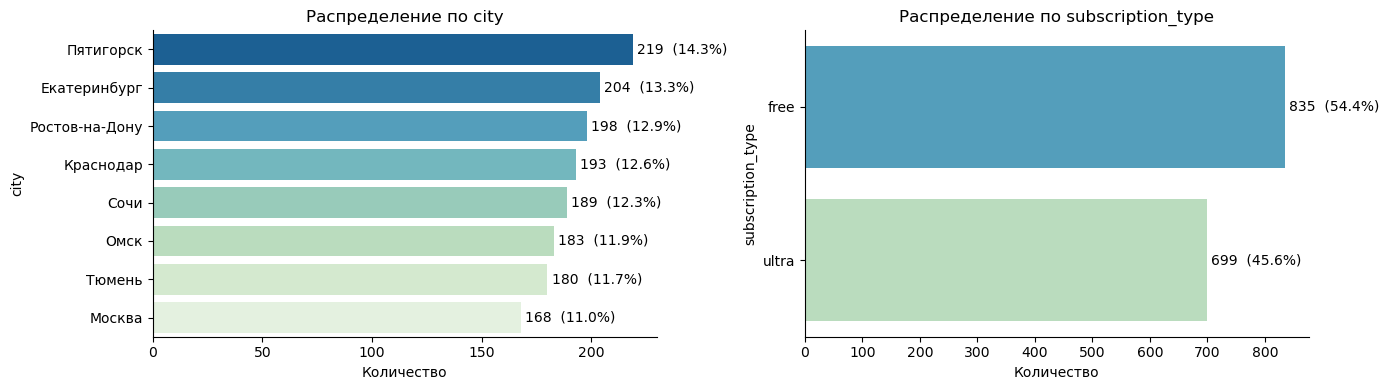

In [10]:
# столбчатые диаграммы категориальных признаков
f_plot_bar(df_users[['city', 'subscription_type']], top_n=10)

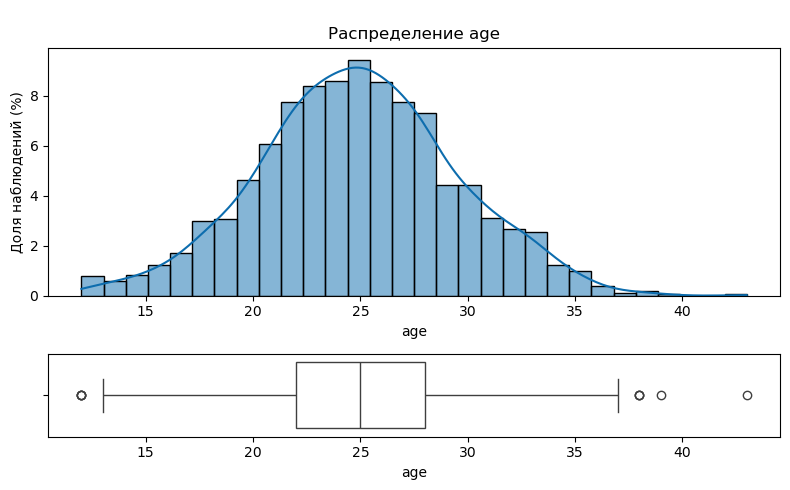

,age
count,1534.000000
mean,24.903520
std,4.572367
min,12.000000
25%,22.000000
50%,25.000000
75%,28.000000
max,43.000000


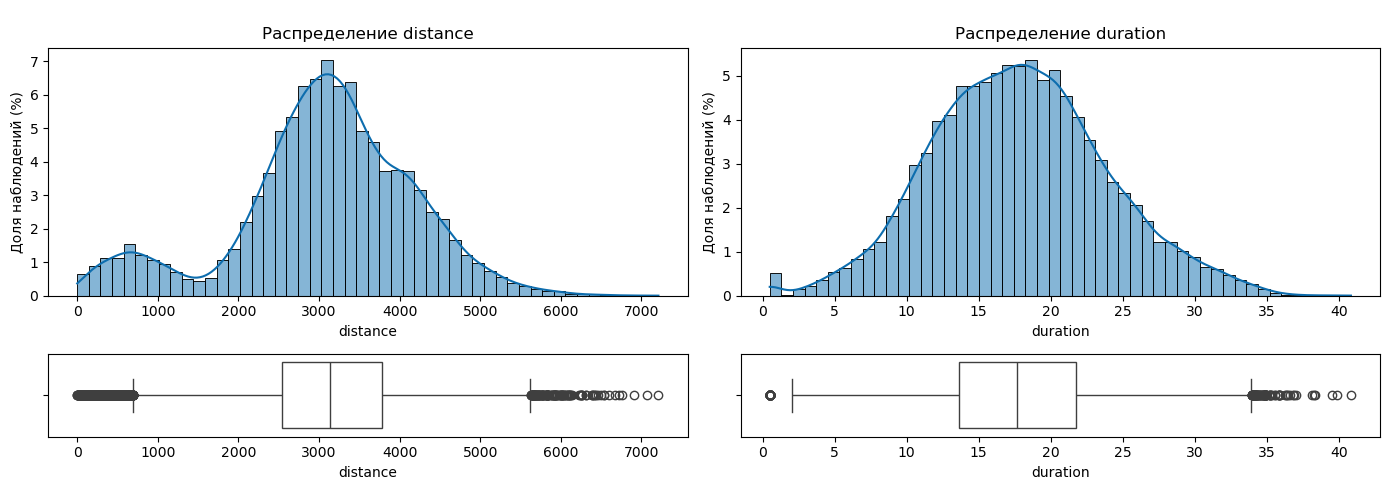

,distance,duration
count,18068.000000,18068.000000
mean,3070.659976,17.805011
std,1116.831209,6.091051
min,0.855683,0.500000
25%,2543.226360,13.597563
50%,3133.609994,17.678395
75%,3776.222735,21.724800
max,7211.007745,40.823963


In [11]:
# гистограмма и диаграмма размаха для количественных признаков 
f_boxplot_histplot_describe(df_users[['age']])
f_boxplot_histplot_describe(df_rides[['distance', 'duration']])

- `city`: В предоставленном наборе данных чаще всего встречаются пользователи из Пятигорска и Екатеринбурга (чуть более 200 записей по каждому городу). Также высока частота встречаемости городов Ростов-на-Дону, Краснодар и Сочи (примерно 190 записей). Меньше всего пользователей из Москвы (168 записей).
- `subscription_type`: График показывает, что в наборе данных больше пользователей с бесплатным доступом (free) к сервису, чем с платной подпиской ultra (835 записей против 699), но дисбаланс не критичен.
- `age`: Большинство пользователей находятся в возрасте от 22 до 28 лет. Пик гистограммы приходится на возрастной отметке 25 лет. Гистограмма имеет форму, близкую к нормальному распределению, с небольшим перекосом в сторону более молодых пользователей.
- `distance`: Распределение имеет бимодальный характер, что может отражать два типа поездок. Большинство пользователей совершают поездки на расстояние до 3800 метров. Пик гистограммы приходится на расстояние около 3070 метров. Распределение асимметрично вправо, что говорит о наличии длинных поездок, которые встречаются реже. Выбросы не выглядят аномальными.
- `duration`: Большинство поездок на самокатах длятся от 13 до 22 минут. Гистограмма имеет форму, близкую к нормальному распределению. Это означает, что большая часть поездок имеет продолжительность, близкую к средней. Для данного графика это около 17 минут.

## Шаг 4. Объединение данных

### Объединение данных о пользователях, поездках и подписках в один датафрейм

In [12]:
# объединение данных
df = df_users.merge(df_rides, on='user_id', how='left')
df = df.merge(df_subscriptions, on='subscription_type', how='left')

# вывод новой таблицы
df

,user_id,name,age,city,subscription_type,distance,duration,date,month_date,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


### Создание отдельных датафреймой c данными о пользователях без подписки и с подпиской

In [13]:
# создание датафрейма c данными о пользователях без подписки
df_subscription_free = df.query('subscription_type == "free"')

# вывод новой таблицы
df_subscription_free

,user_id,name,age,city,subscription_type,distance,duration,date,month_date,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [14]:
# создание датафрейма c данными о пользователях с подпиской;
df_subscription_ultra = df.query('subscription_type == "ultra"')

# вывод новой таблицы
df_subscription_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month_date,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

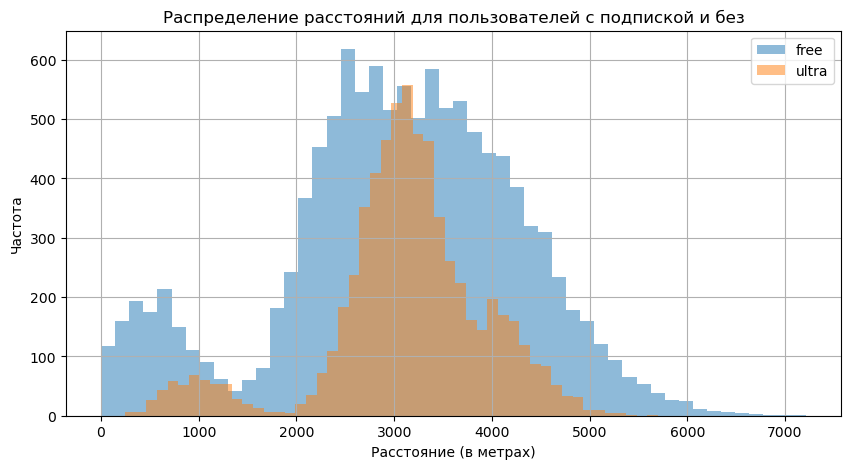

In [15]:
# гистограмма расстояний для пользователей с подпиской и без
plt.figure(figsize=(10, 5))
plt.hist(df_subscription_free['distance'], bins=50, alpha=0.5, label='free')
plt.hist(df_subscription_ultra['distance'], bins=50, alpha=0.5, label='ultra')
plt.legend()
plt.title('Распределение расстояний для пользователей с подпиской и без')
plt.xlabel('Расстояние (в метрах)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Распределения расстояний для пользователей с подпиской и без неё в целом схожи по форме — оба имеют бимодальный характер с основным пиком около 3000 м.
Пользователи с подпиской "ultra" склонны совершать поездки на средние расстояния, а пользователи без подписки (free) чаще делают как очень короткие (менее 1000 м), так и очень длинные (более 5000 м) поездки. 

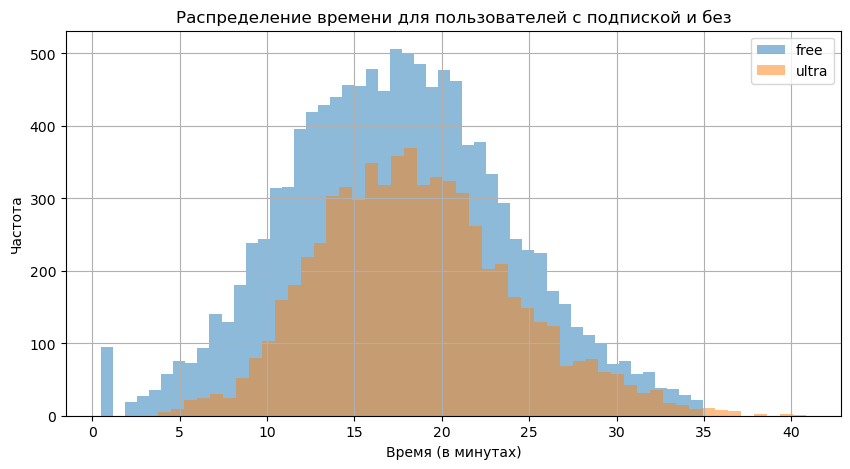

In [16]:
# гистограмма времени поездок для пользователей с подпиской и без
plt.figure(figsize=(10, 5))
plt.hist(df_subscription_free['duration'], bins=50, alpha=0.5, label='free')
plt.hist(df_subscription_ultra['duration'], bins=50, alpha=0.5, label='ultra')
plt.legend()
plt.title('Распределение времени для пользователей с подпиской и без')
plt.xlabel('Время (в минутах)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Гистограмма времени поездок для пользователей без подписки (free) немного смещена влево относительно гистограммы для пользователей с подпиской "ultra". Это значит, что пользователи с подпиской, в среднем, ездят немного дольше - 18.5 минут, в то время как среднее время поездок у пользователей без подписки составляет 17.4 минуты.

## Шаг 5. Подсчёт выручки

### Агрегация данных о поездках по пользователям и месяцам

In [17]:
# округление расстояния
df['distance'] = np.ceil(df['distance'] * 100) / 100

In [18]:
# cоздание агрегированной таблицы
df_aggregated = df.groupby(['user_id','month_date']).agg(rides_count=('user_id', 'count'), \
                                                         total_distance=('distance', 'sum'), \
                                                         total_duration=('duration', 'sum')).reset_index()

# вывод новой таблицы
df_aggregated.head()

,user_id,month_date,rides_count,total_distance,total_duration
0,1,1,2,7027.52,41.416640
1,1,4,1,754.16,6.232113
2,1,8,2,6723.48,44.776802
3,1,10,2,5809.93,31.578017
4,1,11,3,7003.52,53.397424


###  Расчет помесячной выручки по каждому пользователю

In [19]:
# промежуточная таблица с информацией о тарифе по каждому клиенту
users_subscriptions = df[['user_id', 'minute_price', 'start_ride_price', 
                          'subscription_fee', 'subscription_type']].drop_duplicates()

# объединение данных с таблицей df_aggregated
df_aggregated = df_aggregated.merge(users_subscriptions, on='user_id', how='left')

# рассчет помесячной стоимости поездки
df_aggregated['cost_for_month'] = df_aggregated['start_ride_price'] * df_aggregated['rides_count'] + \
                                df_aggregated['minute_price'] * np.ceil(df_aggregated['total_duration']) + \
                                df_aggregated['subscription_fee']
# удаление лишних столбцов
df_aggregated = df_aggregated.drop(['minute_price', 'start_ride_price', 'subscription_fee'], axis=1)

# вывод таблицы
df_aggregated.head()

,user_id,month_date,rides_count,total_distance,total_duration,subscription_type,cost_for_month
0,1,1,2,7027.52,41.416640,ultra,451.0
1,1,4,1,754.16,6.232113,ultra,241.0
2,1,8,2,6723.48,44.776802,ultra,469.0
3,1,10,2,5809.93,31.578017,ultra,391.0
4,1,11,3,7003.52,53.397424,ultra,523.0


## Шаг 6. Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки?

**Гипотезы:**
- $H_0$: средние значения времени поездок пользователей из двух групп равны.
- $H_1$: среднее время поездки пользователей с подпиской больше, чем среднее время поездки пользователей без подписки.

In [20]:
# уровень статистической значимости
alpha = 0.05

# Проверка гипотезы
results = st.ttest_ind(df_subscription_ultra['duration'], df_subscription_free['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Вывод:**

Полученное значение p-value меньше заданного уровня статистической значимости, поэтому можно отвергнуть нулевую гипотезу. Это значит, что пользователи с подпиской тратят больше времени на поездки.

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката?

**Гипотезы:**
- $H_0$: среднее расстояние поездок пользователей с подпиской не превышает 3130 метров.
- $H_1$: среднее расстояние поездок пользователей с подпиской превышает 3130 метров.

In [21]:
middle_distance = 3130

# уровень статистической значимости
alpha = 0.05 

# Проверка гипотезы
results = st.ttest_1samp(df_subscription_ultra['distance'], middle_distance, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


**Вывод:**

Полученное значение p-value (0.9) больше заданного уровня статистической значимости, то есть отвергнуть нулевую гипотезу нельзя. Среднее расстояние поездок пользователей с подпиской не превышает 3130 метров.

### Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Гипотезы:**
- $H_0$: средняя помесячная выручка от пользователей с подпиской не отличается от средней помесячной выручки от пользователей без подписки.
- $H_1$: средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки.

In [22]:
monthly_revenue_ultra = df_aggregated[df_aggregated['subscription_type'] == 'ultra']['cost_for_month']
monthly_revenue_free = df_aggregated[df_aggregated['subscription_type'] == 'free']['cost_for_month']

# уровень статистической значимости
alpha = 0.05

# Проверка гипотезы
results = st.ttest_ind(monthly_revenue_ultra, monthly_revenue_free, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


**Вывод:**

Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

### Проверка влияния обновления сервера на количество обращений в техподдержку

Для проверки данной гипотезы необходимо провести тест о равенстве средних для зависимых (парных) выборок

**Формулировка гипотез:**

- $H_0$: среднее количество обращений до и после обновления не изменилось. 
- $H_1$: среднее количество обращений после обновления уменьшилось.

## Шаг 7. Распределения

### Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %

Минимальное количество промокодов для 5% вероятности невыполнения план: 1172


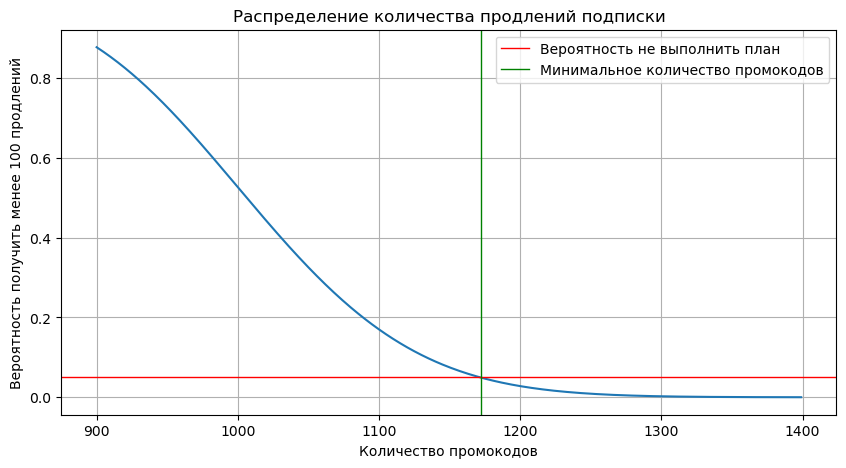

In [23]:
p = 0.1  # вероятность продления подписки
k = 100  # минимальное количество успешных исходов
alpha = 0.05  # вероятность не выполнить план

distr = []

for n in range(900, 1400):
    current_value = st.binom.cdf(k, n, p)
    distr.append(current_value)

# минимальное количество промокодов для 5% вероятности невыполнения план
min_promocodes = np.argmax(np.array(distr) <= alpha) + 900

print(f"Минимальное количество промокодов для 5% вероятности невыполнения план: {min_promocodes}")

# график
plt.figure(figsize=(10, 5))
plt.plot(range(900, 1400), distr)
plt.title('Распределение количества продлений подписки')
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность получить менее 100 продлений')
plt.axhline(y=alpha, color='red', linestyle='-', linewidth=1, label='Вероятность не выполнить план')
plt.axvline(x=min_promocodes, color="green", linewidth=1, linestyle="-", label='Минимальное количество промокодов')
plt.legend()
plt.grid(True)
plt.show()

Необходимо разослать не менее 1172 промокодов, чтобы вероятность не выполнить план была примерно 5%

###  Оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей

In [24]:
# параметры биномиального распределения
n = 1000000  # количество уведомлений
p = 0.4  # вероятность открытия уведомления

# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = math.sqrt(n * p * (1 - p))

# нормальное распределение
distr = st.norm(mu, sigma) 

# определение вероятности хвоста слева от 399,5 тыс.
result = distr.cdf(399500)

print(f"Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей: {result:.3f}")

Вероятность того, что уведомление откроют не более 399.5 тыс. пользователей: 0.154


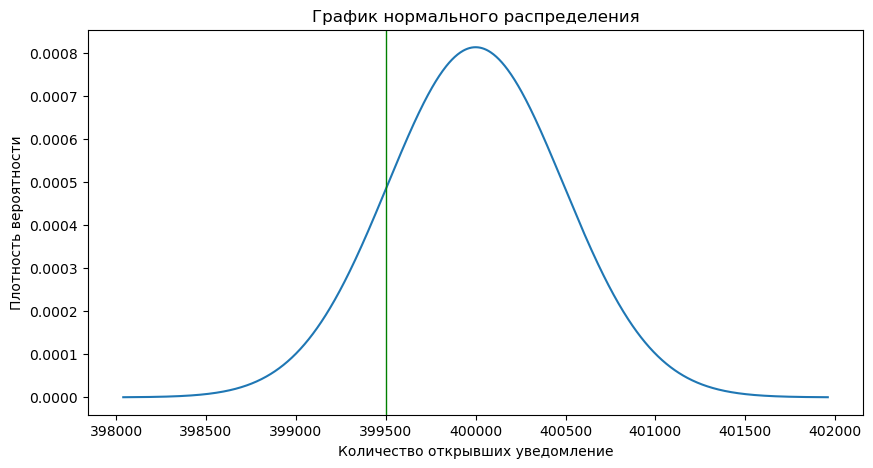

In [25]:
# границы промежутка, в котором будем строить аппроксимацию 
left = int(mu - 4 * sigma)
right = int(mu + 4 * sigma)

# Построение графика нормального распределения
plt.figure(figsize=(10, 5))
x = np.linspace(left, right, 1000)
plt.plot(x, st.norm.pdf(x, mu, sigma))
plt.title("График нормального распределения")
plt.xlabel("Количество открывших уведомление")
plt.ylabel("Плотность вероятности")
plt.axvline(x=399500, color="green", linewidth=1, linestyle="-")
plt.show()

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет 0.154

## Шаг 8. Общий вывод

Для анализа были получены данные из популярного сервиса аренды самокатов - информация о пользователях из нескольких городов, а также об их поездках. 

Целью исследования являлось определение ключевых характеристик пользователей сервиса и проверка гипотез о влиянии платной подписки на поведение пользователей. 

На этапе **предобработки данных** были выполнены следующие действия:
- Преобразование строковой записи столбца date к типу даты pandas
- Создание нового столбца с номером месяца. Это необходимо для дальнейшего анализа
- Удаление дубликатов из таблицы с информацией о пользователях (31 строка)

Поскольку данные были предоставлены в качественном формате, то дальнейшая сложная предобработка не потребовалась.

**Исследовательский анализ** данных показал следующие ключевые особенности:

- Пользователи преимущественно сосредоточены в Пятигорске, Екатеринбурге, Ростове-на-Дону, Краснодаре и Сочи. Количество пользователей из Москвы значительно ниже, чем из других городов
- В наборе данных значительно больше пользователей с бесплатным доступом к сервису по сравнению с пользователями с платной подпиской ultra
- Большинство пользователей имеют возраст от 22 до 28 лет, с пиком в 25 лет
- Большинство поездок на самокатах совершаются на относительно короткие расстояния (до 3800 метров), с пиком около 3070 метров
- Большинство поездок на самокатах длятся от 13 до 22 минут, с пиком около 17 минут
- Пользователи с подпиской "ultra" склонны к более стандартным поездкам - средняя продолжительность и среднее расстояние
- Пользователи с бесплатным доступом (free) чаще совершают как очень короткие (менее 1000 м), так и очень длинные (более 5000 м) поездки по сравнению с пользователями с подпиской ultra
- Среднее время поездок у пользователей с подпиской "ultra" чуть больше, чем у пользователей без подписки (18.5 мин. и 17,4 мин соответственно)

**Проверка гипотез** показала следующие выводы:

- Пользователи с подпиской тратят больше времени на поездки
- Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки


Дополнительно для отдела маркетинга было сделано:
- Найдено минимальное количество промокодов для выполнения плана продаж на 95%: количество промокодов 1172 
- Найдена вероятность того, что уведомление откроют не более 399,5 тыс. пользователей из 1 млн: вероятность 0.154